In [11]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from isaac.constants import FORCE_CLASS_COLS, MASS_CLASS_COLS, BASIC_TRAINING_COLS, PUCK_SQUARE_DISTANCES, PUCK_ANGLE_FEATURES
from isaac.evaluation import evaluate_saved_model, evaluate
from isaac.dataset import read_dataset
from isaac.models import MultiBranchModel
from isaac.visualization import plot_confusion_matrix_given_predicted_and_test_loader
from isaac.noise import add_noise_to_dataloader

In [12]:
from isaac.utils import get_cuda_device_if_available, create_directory
device = get_cuda_device_if_available()
print(device)

cuda:0


In [13]:
network_dims = (len(BASIC_TRAINING_COLS), 25, 3)

In [14]:
directory = "testing_on_noisy_data/"
create_directory(directory)

In [15]:
def get_accuracy_and_predicted(model_path, multiclass_index, question_class_columns):

    training_columns = BASIC_TRAINING_COLS
    class_columns = [list(MASS_CLASS_COLS), list(FORCE_CLASS_COLS)]
    scaler_path = "scalers/passive_dual_scaler.sk"

    plot_path = directory+"passive_data_"+question_type+"_model_cm.pdf"

    test_dataset_path = "data/test_passive_trials.h5"    

    accuracy, predicted, test_loader = evaluate_saved_model(model_path, network_dims, test_dataset_path,
                                                            training_columns, class_columns, scaler_path=scaler_path, 
                                                            arch=MultiBranchModel, multiclass=True, 
                                                            device=device, return_test_loader=True, seq_start=None,
                                                            seq_end=1800, step_size=3)

    accuracy = accuracy[multiclass_index]
    predicted = predicted[:, multiclass_index]

    """print(accuracy)
    ax = plot_confusion_matrix_given_predicted_and_test_loader(predicted, test_loader, question_class_columns, 
                                                               save_plot_path=plot_path, multiclass_index=multiclass_index)"""
    return accuracy, predicted, test_loader

def get_noisy_accuracy_and_predicted(model_path, noise_deviation, test_loader, multiclass_index, question_class_columns):
    model = MultiBranchModel(*network_dims)
    model.load_state_dict(torch.load(model_path, map_location="cpu"))
    model = model.to(device="cuda:0")
    model = model.eval()

    noisy_test_loader = add_noise_to_dataloader(test_loader, noise_deviation=noise_deviation)

    noisy_accuracy, noisy_predicted = evaluate(model, noisy_test_loader, return_predicted=True, 
                                   seq_start=None, step_size=3, seq_end=1800)

    noisy_accuracy = noisy_accuracy[multiclass_index]
    noisy_predicted = noisy_predicted[:, multiclass_index]

    """print(accuracy)
    ax = plot_confusion_matrix_given_predicted_and_test_loader(predicted, noisy_test_loader, question_class_columns, 
                                                               save_plot_path=plot_path, multiclass_index=multiclass_index)"""
    return noisy_accuracy, noisy_predicted

In [16]:
import glob

In [17]:
noise_levels = [0., 0.025, 0.0625, 0.125, 0.25, 0.5, 0.75, 1]

In [18]:
def get_noisy_accuracy_list(noise_levels, multiclass_index, question_class_columns):
    noisy_accuracies = []

    _, _, test_loader = get_accuracy_and_predicted("models/best_force_model_seed_0.pt", multiclass_index, question_class_columns)

    for model_path in glob.glob("models/*"+question_type+"*.pt"):
        model_accuracies = []
        for noise_deviation in noise_levels:
            noisy_accuracy, _ = get_noisy_accuracy_and_predicted(model_path, noise_deviation, test_loader, multiclass_index, question_class_columns)
            model_accuracies.append(noisy_accuracy)
        noisy_accuracies.append(model_accuracies)
        
    return noisy_accuracies

In [19]:
question_type = "mass"
mass_noisy_accuracies = get_noisy_accuracy_list(noise_levels, 0, MASS_CLASS_COLS)
question_type = "force"
force_noisy_accuracies = get_noisy_accuracy_list(noise_levels, 1, FORCE_CLASS_COLS)

100%|██████████| 1000/1000 [00:01<00:00, 719.24it/s]


Model's accuracy on test set: [63.7 59.4]


100%|██████████| 1000/1000 [00:01<00:00, 653.35it/s]


Model's accuracy on test set: [63.7 59.4]


Text(0.5, 0, 'Noise SD')

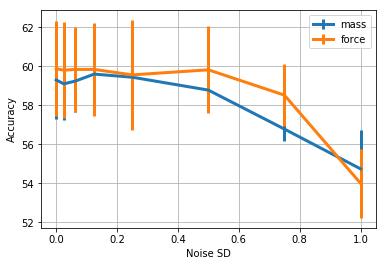

In [20]:
plt.errorbar(noise_levels, np.mean(mass_noisy_accuracies, axis=0), yerr=np.std(mass_noisy_accuracies, axis=0), linewidth=3, label="mass")
plt.errorbar(noise_levels, np.mean(force_noisy_accuracies, axis=0), yerr=np.std(force_noisy_accuracies, axis=0), linewidth=3, label="force")
plt.legend()
plt.grid()
plt.ylabel("Accuracy")
plt.xlabel("Noise SD")